In [1]:
import pandas as pd

df = pd.read_csv("yeobo.csv")

df["강수여부"] = df["일강수량(mm)"].apply(lambda x: 1 if pd.notna(x) and x > 0 else 0)

mean_cloud_with_rain = df.loc[df["강수여부"] == 1, "평균 전운량(1/10)"].mean()
mean_cloud_without_rain = df.loc[df["강수여부"] == 0, "평균 전운량(1/10)"].mean()

def fill_cloud(row):
    if pd.isna(row["평균 전운량(1/10)"]):
        return mean_cloud_with_rain if row["강수여부"] == 1 else mean_cloud_without_rain
    else:
        return row["평균 전운량(1/10)"]

df["평균 전운량(1/10)"] = df.apply(fill_cloud, axis=1)

df.to_csv("yeobo_processed.csv", index=False)


In [3]:
df = pd.read_csv("yeobo_processed.csv")
print(df['강수여부'])

0        1
1        0
2        0
3        0
4        1
        ..
14607    0
14608    1
14609    0
14610    0
14611    0
Name: 강수여부, Length: 14612, dtype: int64


In [7]:
import pandas as pd

# 1. 파일 불러오기
df = pd.read_csv("yeobo.csv")

# 2. 날짜 타입으로 변환 및 정렬
df["일시"] = pd.to_datetime(df["일시"])
df = df.sort_values("일시")
df.set_index("일시", inplace=True)

# 3. 강수여부 생성
df["강수여부"] = df["일강수량(mm)"].apply(lambda x: 1 if pd.notna(x) and x > 0 else 0)

# 4. 평균 전운량 결측치 채우기
mean_cloud_with_rain = df.loc[df["강수여부"] == 1, "평균 전운량(1/10)"].mean()
mean_cloud_without_rain = df.loc[df["강수여부"] == 0, "평균 전운량(1/10)"].mean()

df["평균 전운량(1/10)"] = df.apply(
    lambda row: mean_cloud_with_rain if pd.isna(row["평균 전운량(1/10)"]) and row["강수여부"] == 1
    else mean_cloud_without_rain if pd.isna(row["평균 전운량(1/10)"]) else row["평균 전운량(1/10)"],
    axis=1
)

# 5. 풍속 및 상대습도 결측 보완
# interpolate (시간 기준, limit=1)
for col in ["평균 풍속(m/s)", "평균 상대습도(%)"]:
    df[col] = df[col].interpolate(method="time", limit=1)

# 평균 풍속 보완 (월/일 기준 과거 평균)
df["월"] = df.index.month
df["일"] = df.index.day

for col in ["평균 풍속(m/s)"]:
    daily_avg = df.groupby(["월", "일"])[col].transform("mean")
    df[col] = df[col].fillna(daily_avg)

# 상대습도 보완 (전체 평균값)
for col in ["평균 상대습도(%)"]:
    df[col] = df[col].fillna(df[col].mean())

# 6. 정리 후 저장
df.drop(columns=["월", "일"], inplace=True)
df.reset_index(inplace=True)
df.to_csv("yeobo_processed.csv", index=False)


In [26]:
df = pd.read_csv("yeobo_processed.csv")
df.isna().sum()

일시                      0
지점                      0
지점명                     0
평균기온(°C)                7
일강수량(mm)             8034
평균 풍속(m/s)              0
평균 이슬점온도(°C)            7
평균 상대습도(%)              0
평균 증기압(hPa)             7
평균 현지기압(hPa)            8
평균 해면기압(hPa)            8
합계 일조시간(hr)            29
합계 일사량(MJ/m2)        7038
일 최심신적설(cm)         14525
일 최심적설(cm)          14515
합계 3시간 신적설(cm)      14525
평균 전운량(1/10)            0
평균 중하층운량(1/10)       3855
평균 지면온도(°C)            29
평균 5cm 지중온도(°C)     10973
평균 10cm 지중온도(°C)    10974
평균 20cm 지중온도(°C)    10980
평균 30cm 지중온도(°C)    10964
합계 대형증발량(mm)         7811
합계 소형증발량(mm)         7586
9-9강수(mm)           11216
안개 계속시간(hr)         14385
강수여부                    0
dtype: int64

In [38]:
df = pd.read_csv("yeobo.csv")
print(df.isna().sum())

지점                      0
지점명                     0
일시                      0
평균기온(°C)                7
일강수량(mm)             8034
평균 풍속(m/s)             44
평균 이슬점온도(°C)            7
평균 상대습도(%)              6
평균 증기압(hPa)             7
평균 현지기압(hPa)            8
평균 해면기압(hPa)            8
합계 일조시간(hr)            29
합계 일사량(MJ/m2)        7038
일 최심신적설(cm)         14525
일 최심적설(cm)          14515
합계 3시간 신적설(cm)      14525
평균 전운량(1/10)         3550
평균 중하층운량(1/10)       3855
평균 지면온도(°C)            29
평균 5cm 지중온도(°C)     10973
평균 10cm 지중온도(°C)    10974
평균 20cm 지중온도(°C)    10980
평균 30cm 지중온도(°C)    10964
합계 대형증발량(mm)         7811
합계 소형증발량(mm)         7586
9-9강수(mm)           11216
안개 계속시간(hr)         14385
dtype: int64


In [40]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # MICE 기능 활성화
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# 결측치 0으로 처리할 열
fill_zero_columns = ['일강수량(mm)', '일 최심신적설(cm)']
for col in fill_zero_columns:
    null_count = df[col].isnull().sum()
    df[col] = df[col].fillna(0)
    print(f"[{col}] 결측치 {null_count}개를 0으로 채움.")


target_columns = [
    '평균기온(°C)', '평균 풍속(m/s)','평균 상대습도(%)','평균 전운량(1/10)','평균 지면온도(°C)', ']

imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    max_iter=10,
    random_state=42
)

# 수치형 데이터만 선택 (특히 대상 열만 사용)
imputed_data = imputer.fit_transform(df[target_columns])

# 결과를 원래 데이터프레임에 반영
df[target_columns] = imputed_data

# 저장
df.to_csv("weather_all_data_filled_mice.csv", index=False, encoding="utf-8-sig")
print("MICE 방식(RandomForest 기반)으로 결측치 채우기 완료 및 저장됨")


[일강수량(mm)] 결측치 0개를 0으로 채움.
[일 최심신적설(cm)] 결측치 0개를 0으로 채움.
MICE 방식(RandomForest 기반)으로 결측치 채우기 완료 및 저장됨


C:\Users\MINJUN\Documents\GitHub\Data_Baisc_Analyze\Data_Baisc_Analyze\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [42]:
df = pd.read_csv("weather_all_data_filled.csv")
print(df.isna().sum())

지점                      0
지점명                     0
일시                      0
평균기온(°C)                0
일강수량(mm)                0
평균 풍속(m/s)              0
평균 이슬점온도(°C)            7
평균 상대습도(%)              0
평균 증기압(hPa)             7
평균 현지기압(hPa)            8
평균 해면기압(hPa)            8
합계 일조시간(hr)            29
합계 일사량(MJ/m2)        7038
일 최심신적설(cm)             0
일 최심적설(cm)          14515
합계 3시간 신적설(cm)      14525
평균 전운량(1/10)            0
평균 중하층운량(1/10)       3855
평균 지면온도(°C)             0
평균 5cm 지중온도(°C)     10973
평균 10cm 지중온도(°C)    10974
평균 20cm 지중온도(°C)    10980
평균 30cm 지중온도(°C)    10964
합계 대형증발량(mm)         7811
합계 소형증발량(mm)         7586
9-9강수(mm)           11216
안개 계속시간(hr)         14385
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# 파일 불러오기
file_path = "./mice2.csv"
df = pd.read_csv(file_path)

fill_zero_columns = ['일강수량(mm)', '일 최심신적설(cm)']
for col in fill_zero_columns:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        print(f"[{col}] 결측치 {null_count}개를 0으로 채움.")


target_columns = [
    '최대 순간 풍속 풍향(16방위)','최대 순간풍속 시각(hhmi)','최대 풍속 풍향(16방위)','최대 풍속 시각(hhmi)','풍정합(100m)','최다풍향(16방위)',
    '가조시간(hr)','합계 일조시간(hr)','1시간 최다일사 시각(hhmi)','1시간 최다일사량(MJ/m2)','합계 일사량(MJ/m2)','평균 중하층운량(1/10)',
    '최저 초상온도(°C)','평균 5cm 지중온도(°C)','평균 10cm 지중온도(°C)','평균 20cm 지중온도(°C)','평균 30cm 지중온도(°C)'
]

# MICE 기반 대체 수행
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    max_iter=10,
    random_state=42
)

imputed_data = imputer.fit_transform(df[target_columns])
df[target_columns] = imputed_data

# 파일 저장
output_path = "mice3.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(df.isna().sum())

[일강수량(mm)] 결측치 0개를 0으로 채움.
[일 최심신적설(cm)] 결측치 0개를 0으로 채움.


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 📌 1. 파일 로드
# 'mice_data.csv' 파일을 EUC-KR 인코딩으로 읽어옴
df = pd.read_csv("mice_data.csv", encoding="euc-kr")

# 📌 2. 예측에서 제외할 컬럼들 정의
excluded_cols = ['평균 상대습도(%)', '평균 이슬점온도(°C)', '평균 전운량(1/10)', '평균 해면기압(hPa)']

# 📌 3. 날짜 처리
# '일시' 컬럼을 datetime 형식으로 변환한 후, 연/월/일 컬럼을 따로 생성
df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day

# 📌 4. 입력 피처(feature) 컬럼과 예측 대상(target) 컬럼 정의
# - 입력: 연, 월, 일
# - 예측 대상: 제외 컬럼 + 날짜 + 지점 관련 컬럼을 제외한 나머지 컬럼
feature_cols = ['연', '월', '일']
target_cols = [col for col in df.columns if col not in excluded_cols + ['지점', '지점명', '일시'] + feature_cols]

# 📌 5. 2026년 1월 1일부터 12월 31일까지 날짜 생성
# 예측을 위한 미래 데이터프레임 생성
future_dates = pd.date_range(start='2026-01-01', end='2026-12-31')
future_df = pd.DataFrame({
    '일시': future_dates,
    '연': future_dates.year,
    '월': future_dates.month,
    '일': future_dates.day
})

# 📌 6. 예측 결과를 담을 딕셔너리 초기화
# '일시' 컬럼부터 넣어두고, 이후 예측값을 컬럼별로 추가할 예정
results = {'일시': future_dates}

# 📌 7. 각 예측 대상 컬럼마다 모델 학습 및 2026년 데이터 예측
for col in target_cols:
    # 해당 컬럼에 결측치가 있는 행은 제거
    temp_df = df.dropna(subset=[col])
    
    # 입력값: 연/월/일, 타깃값: 해당 컬럼
    X = temp_df[feature_cols]
    y = temp_df[col]

    # 모델 정의 및 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # 2026년 데이터에 대해 예측 수행
    y_pred = model.predict(future_df[feature_cols])
    
    # 결과 딕셔너리에 예측값 추가
    results[col] = y_pred

# 📌 8. 예측 결과를 DataFrame으로 변환한 후 CSV로 저장
predicted_df = pd.DataFrame(results)
predicted_df.to_csv("predicted_2026.csv", index=False, encoding="utf-8-sig")


Temp_Df:         지점  지점명         일시  평균기온(°C)  최저기온(°C)  최고기온(°C)  일강수량(mm)  \
0      184   제주 2015-01-01       3.3       1.7       5.4       4.2   
1      184   제주 2015-01-02       6.1       3.9       8.5       0.0   
2      184   제주 2015-01-03       6.8       3.5       9.6       0.0   
3      184   제주 2015-01-04      11.5       7.7      15.0       0.0   
4      184   제주 2015-01-05      12.9       6.8      17.5       0.7   
...    ...  ...        ...       ...       ...       ...       ...   
14607  189  서귀포 2024-12-27       7.1       5.2      12.1       0.0   
14608  189  서귀포 2024-12-28       5.1       2.7       7.3       0.1   
14609  189  서귀포 2024-12-29       7.3       3.5      12.2       0.0   
14610  189  서귀포 2024-12-30      10.6       6.7      14.6       0.0   
14611  189  서귀포 2024-12-31       8.8       5.3      13.7       0.0   

       최대 순간 풍속(m/s)  최대 풍속(m/s)  평균 풍속(m/s)  ...  평균 증기압(hPa)  평균 현지기압(hPa)  \
0               21.2        12.9         8.3  ...          5.4        

[평균기온(°C)] MSE: 12.79, R²: 0.7857


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) mis

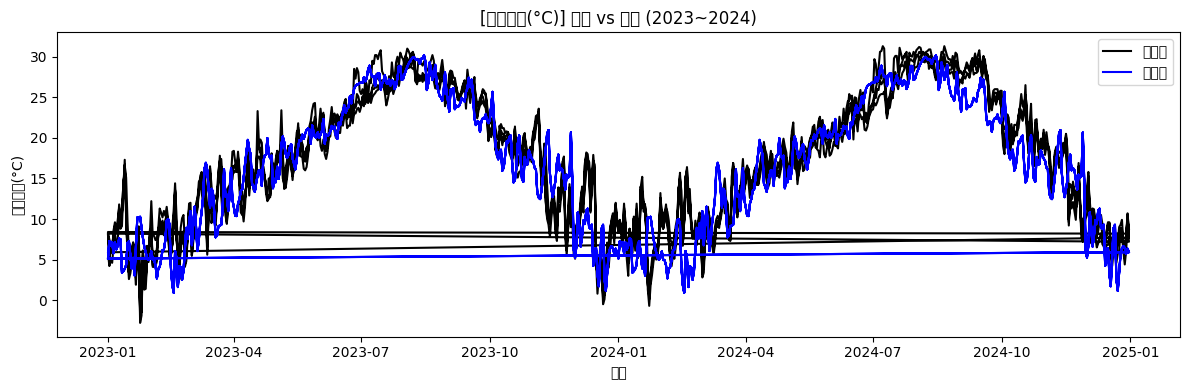

[최저기온(°C)] MSE: 13.90, R²: 0.7836


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing

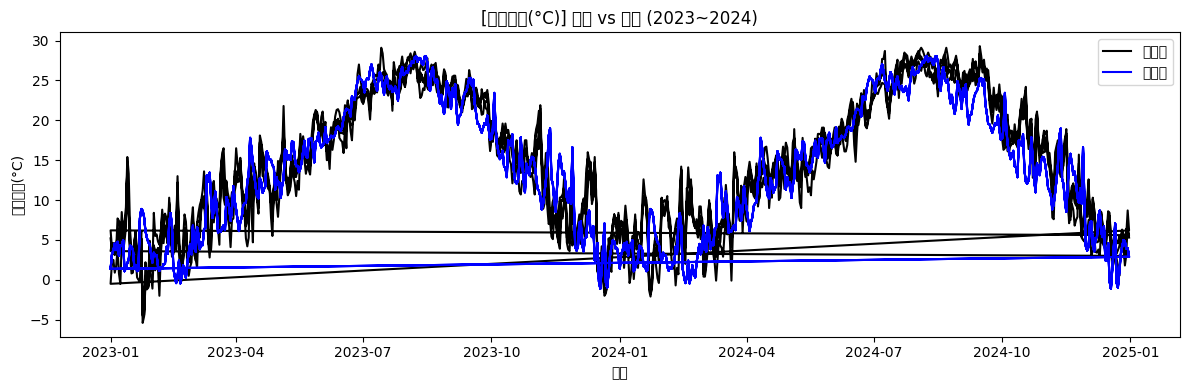

[최고기온(°C)] MSE: 16.52, R²: 0.7250


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing 

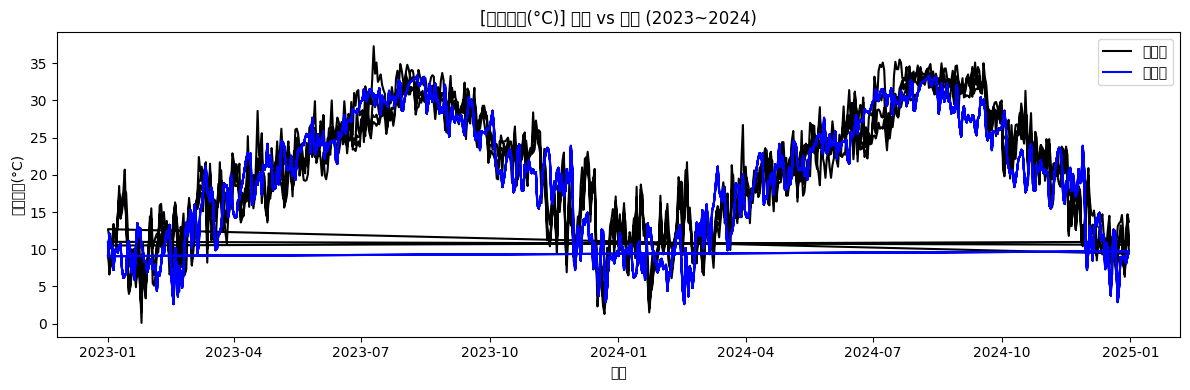

[일강수량(mm)] MSE: 488.81, R²: -0.6752


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) miss

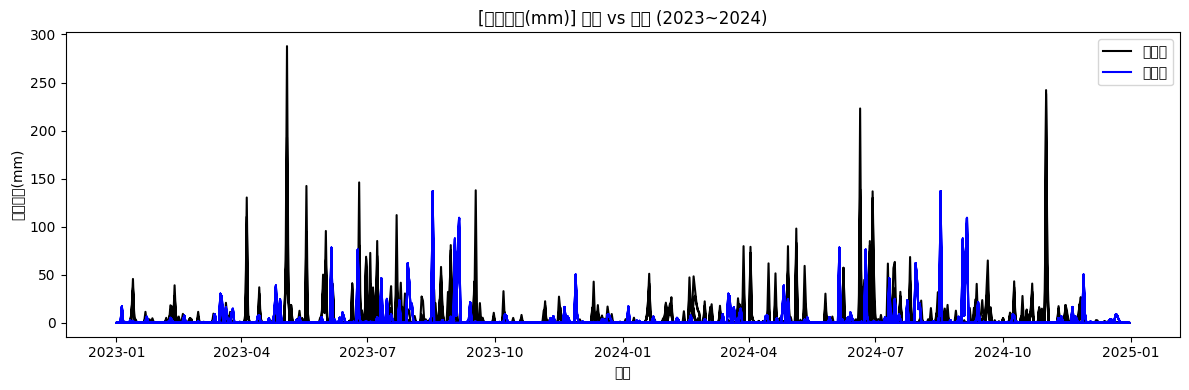

[최대 순간 풍속(m/s)] MSE: 32.27, R²: -0.4125


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missi

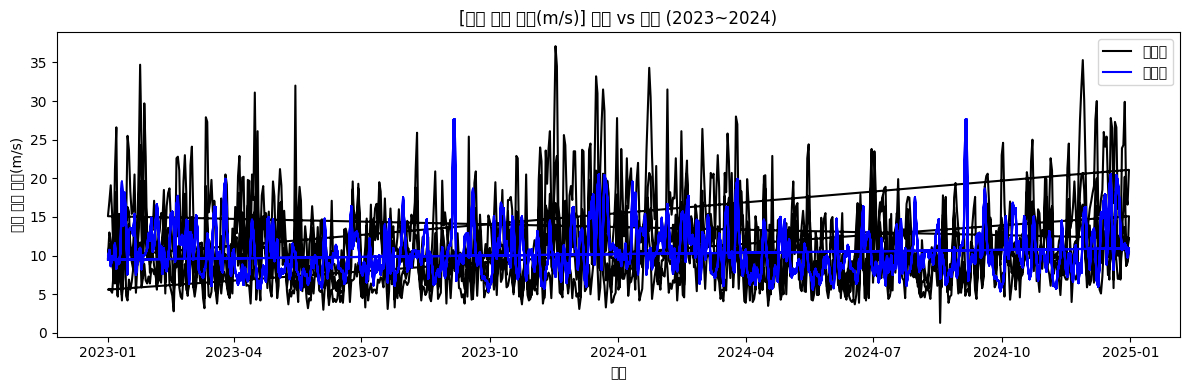

[최대 풍속(m/s)] MSE: 17.76, R²: -0.2695


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) miss

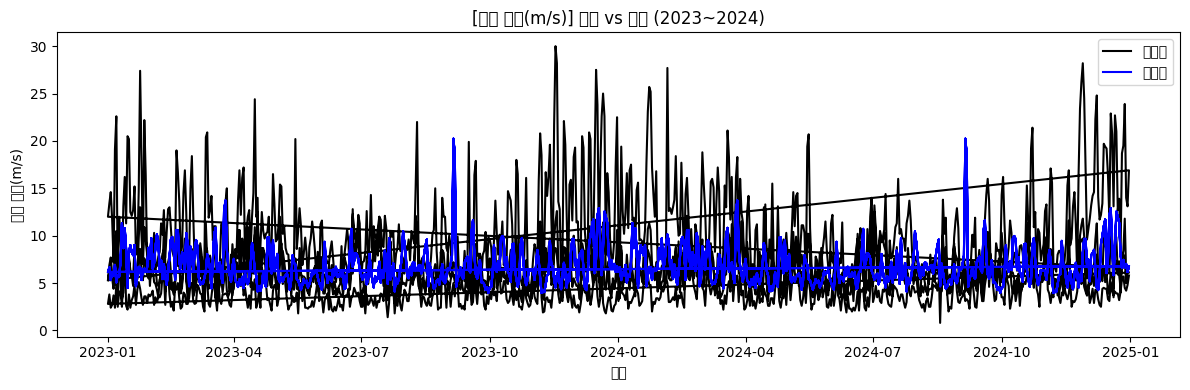

[평균 풍속(m/s)] MSE: 7.72, R²: -0.2100


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) 

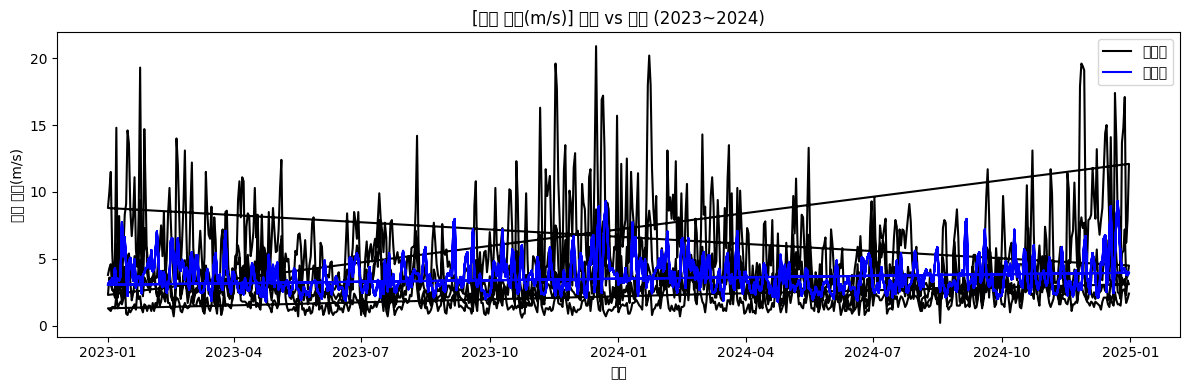

[최소 상대습도(%)] MSE: 349.76, R²: -0.2967


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missi

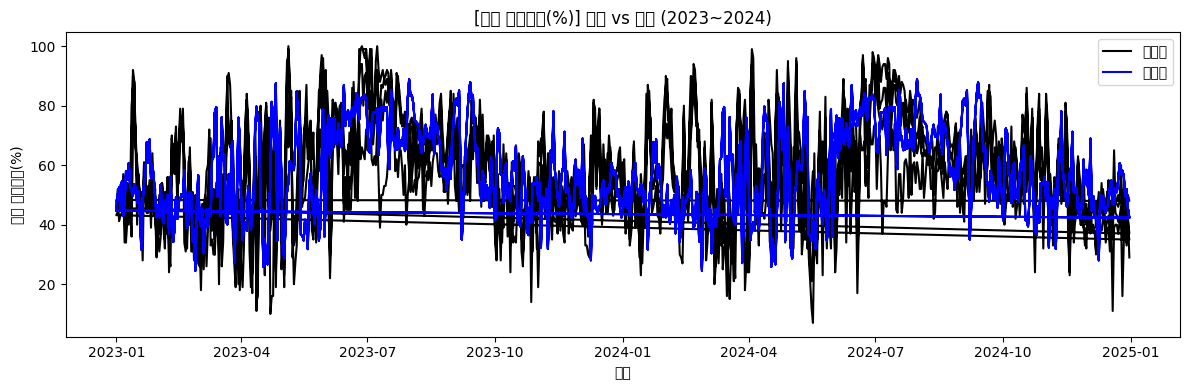

[평균 증기압(hPa)] MSE: 21.89, R²: 0.7307


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) 

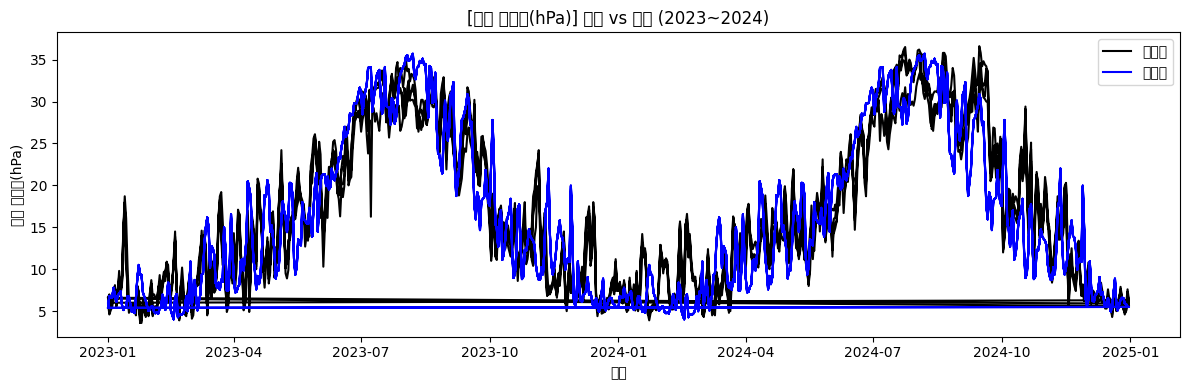

[평균 현지기압(hPa)] MSE: 43.31, R²: 0.2993


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) 

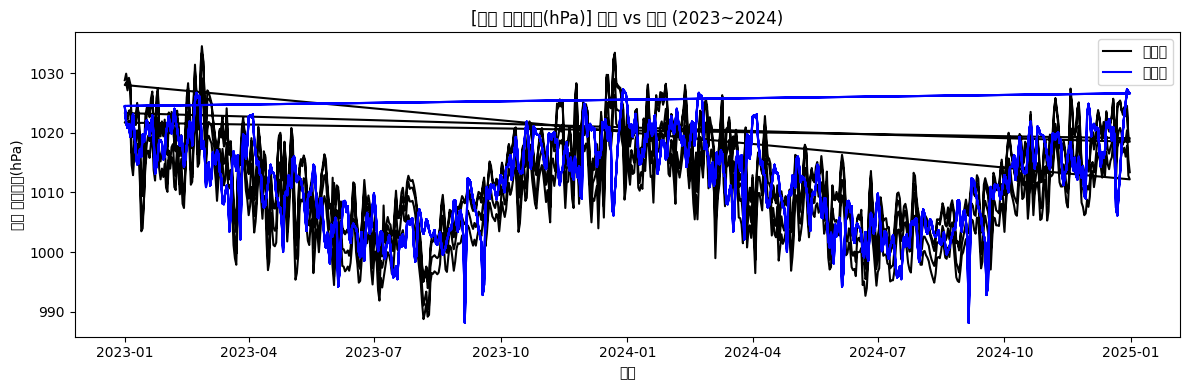

[최저 해면기압(hPa)] MSE: 51.34, R²: 0.0801


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) mis

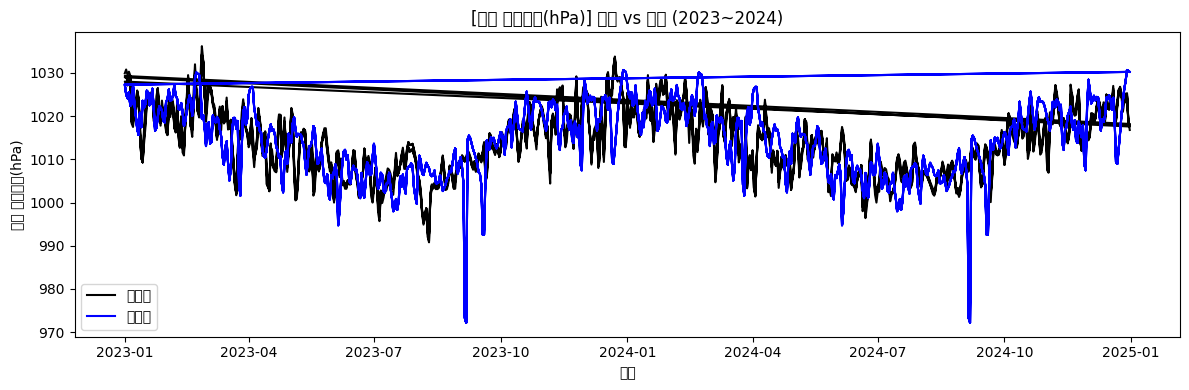

[일 최심신적설(cm)] MSE: 0.06, R²: -0.1452


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missin

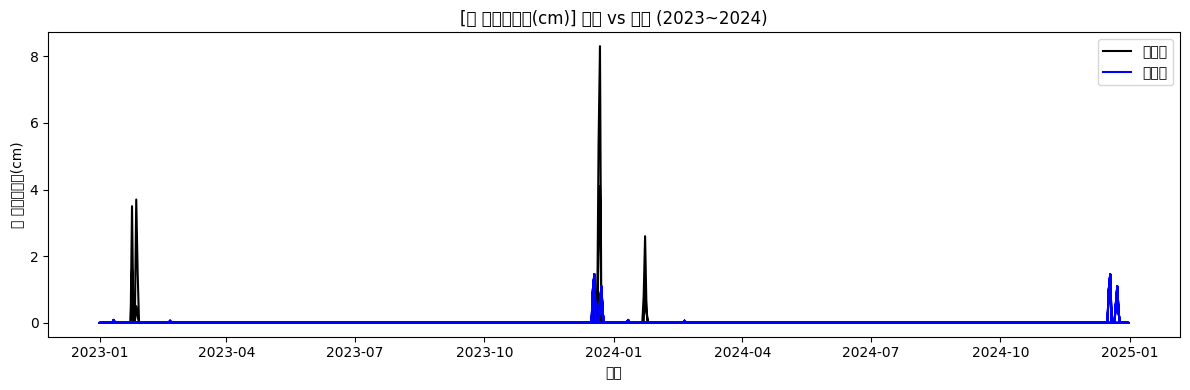

[평균 지면온도(°C)] MSE: 15.43, R²: 0.8121


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_50500\3815442214.py:53: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) 

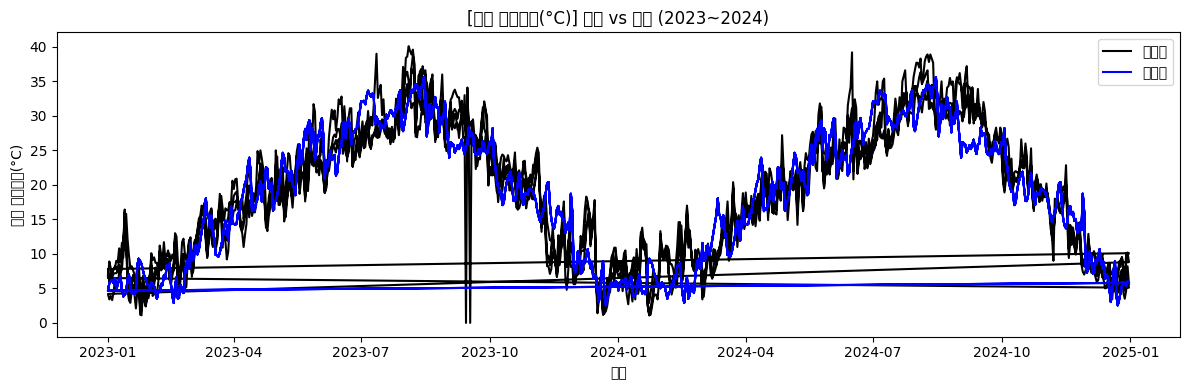

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
df = pd.read_csv("mice_data.csv", encoding="euc-kr")

excluded_cols = ['평균 상대습도(%)', '평균 이슬점온도(°C)', '평균 전운량(1/10)', '평균 해면기압(hPa)']
df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day

feature_cols = ['연', '월', '일']
target_cols = [col for col in df.columns if col not in excluded_cols + ['지점', '지점명', '일시'] + feature_cols]

# 2. 학습용(2015~2022) / 테스트용(2023~2024) 데이터 분리
train_df = df[df['연'] <= 2022]
test_df = df[df['연'].isin([2023, 2024])]

# 3. 컬럼별 성능 평가 및 시각화
for col in target_cols:
    # 결측치 제거
    train_temp = train_df.dropna(subset=[col])
    test_temp = test_df.dropna(subset=[col])

    # 학습 및 테스트 데이터 준비
    X_train = train_temp[feature_cols]
    y_train = train_temp[col]
    X_test = test_temp[feature_cols]
    y_test = test_temp[col]

    # 모델 학습 및 예측
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 정확도 지표 계산
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"[{col}] MSE: {mse:.2f}, R²: {r2:.4f}")

    # 예측 vs 실제 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(test_temp['일시'], y_test, label='실제값', color='black')
    plt.plot(test_temp['일시'], y_pred, label='예측값', color='blue')
    plt.title(f"[{col}] 예측 vs 실제 (2023~2024)")
    plt.xlabel("날짜")
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 1. 데이터 로드
df = pd.read_csv("weather_all_data_cleaned.csv", encoding='euc-kr')  # 또는 'utf-8'로 시도

# 2. 제외할 컬럼 정의
excluded_cols = ['평균 상대습도(%)', '평균 이슬점온도(°C)', '평균 해면기압(hPa)',]

# 3. 날짜 컬럼 처리
df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day

# 4. 예측 대상 컬럼 정의
feature_cols = ['연', '월', '일']
target_cols = [col for col in df.columns if col not in excluded_cols + ['지점', '지점명', '일시'] + feature_cols]

# 5. 2026년 예측용 날짜 데이터 생성
future_dates = pd.date_range(start='2026-01-01', end='2026-12-31')
future_df = pd.DataFrame({
    '일시': future_dates,
    '연': future_dates.year,
    '월': future_dates.month,
    '일': future_dates.day
})

# 6. 지점별 예측 결과 저장용 딕셔너리
results_by_station = {}

# 7. 지점별로 모델 학습 및 예측 수행
for station, group in df.groupby('지점명'):
    results = {'일시': future_dates}
    
    for col in target_cols:
        temp_df = group.dropna(subset=[col])
        X = temp_df[feature_cols]
        y = temp_df[col]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        y_pred = model.predict(future_df[feature_cols])
        results[col] = y_pred

    predicted_df = pd.DataFrame(results)
    predicted_df['지점명'] = station
    results_by_station[station] = predicted_df

# 8. 지점별 결과 병합
combined_df = pd.concat(results_by_station.values(), ignore_index=True)

# 9. CSV로 저장
combined_df.to_csv("2026_예측.csv", index=False, encoding="utf-8-sig")
print(combined_df)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 📌 데이터 불러오기 및 날짜 분해
df = pd.read_csv("weather_all_data_cleaned.csv", encoding='euc-kr')
df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day

# 📌 지점 및 예측 연도 지정
station_name = '서울'
target_year = 2023

# 📌 제외 컬럼 정의
excluded_cols = ['평균 상대습도(%)', '평균 이슬점온도(°C)', '평균 해면기압(hPa)', '지점', '지점명', '일시', '연', '월', '일']
target_cols = [col for col in df.columns if col not in excluded_cols]

# 📌 해당 지점 필터링
df_station = df[df['지점명'] == station_name]

# 📌 학습용, 테스트용 분리
train_df = df_station[df_station['연'] != target_year]
test_df = df_station[df_station['연'] == target_year]

# 📌 반복하여 예측 및 그래프 출력
for target_col in target_cols:
    train_temp = train_df.dropna(subset=[target_col])
    test_temp = test_df.dropna(subset=[target_col])

    if len(test_temp) == 0:  # 예측할 데이터가 없으면 스킵
        continue

    X_train = train_temp[['연', '월', '일']]
    y_train = train_temp[target_col]

    X_test = test_temp[['연', '월', '일']]
    y_test = test_temp[target_col]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 📊 그래프 그리기
    plt.figure(figsize=(14, 5))
    plt.plot(test_temp['일시'], y_test.values, label='실제값', linewidth=2)
    plt.plot(test_temp['일시'], y_pred, label='예측값', linewidth=2, linestyle='--')
    plt.title(f"{station_name} - {target_year}년 [{target_col}] 실제 vs 예측")
    plt.xlabel("날짜")
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os

# 데이터 불러오기
predict_df = pd.read_csv("./2026_예측.csv")
train_df = pd.read_csv("./data_for_predict.csv", encoding="euc-kr")

# 날짜 변환
predict_df['일시'] = pd.to_datetime(predict_df['일시'])
train_df['일시'] = pd.to_datetime(train_df['일시'])

# 비교할 지점명과 비교 연도
station = '고산'
compare_year = 2023

# train 데이터에서 해당 지점 & 연도 필터링
real_df = train_df[(train_df['지점명'] == station) & (train_df['일시'].dt.year == compare_year)]

# 예측 데이터에서 동일 지점만 추출
pred_df = predict_df[predict_df['지점명'] == station]

# 날짜 기준 병합 (내일 예측 등은 시간 시프트 필요하지만 현재는 같은 일자 비교)
merged = pd.merge(real_df, pred_df, on='일시', suffixes=('_실제', '_예측'))

# 비교 가능한 공통 컬럼
common_cols = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', 
               '최대 순간 풍속(m/s)', '최대 풍속(m/s)', '평균 풍속(m/s)',
               '평균 증기압(hPa)', '평균 현지기압(hPa)', '평균 지면온도(°C)']

# 결과 저장 폴더
os.makedirs("scatter_results", exist_ok=True)

# 산점도 그래프 그리기
for col in common_cols:
    col_real = col + '_실제'
    col_pred = col + '_예측'

    if col_real not in merged.columns or col_pred not in merged.columns:
        continue

    y_true = merged[col_real]
    y_pred = merged[col_pred]

    # 성능지표
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='완벽 예측선 (y = x)')
    plt.xlabel(f"{col} 실제값")
    plt.ylabel(f"{col} 예측값")
    plt.title(f"[{station}] {col} 실제 vs 예측\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"scatter_results/{station}_{col}_scatter.png")
    plt.close()


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.